# Time series validation of PCR-GLOBWB nc-ouptput

This notebooks contains a couple of functions facilitating the extraction of time series from GRDC-files and from nc-files containing PCR-GLOBWB output.

The time series can then be plotted individually and futher analysed in some post-processing steps.

The notebook contains additioanl functions to determine monthly averages over the entire time series as well as functions to validate simulations against observations.

In this notebook, the required packages are first loaded. Then, the functions are defined. Third, data is extracted and plotted in cases. Fourth, the daily values are validated. Last, monthly averages are computed and validated as well.

## Load packages and print system information

In [1]:
import pcrglobwb_utils
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import rasterio as rio
import spotpy as sp
import os, sys
import datetime

In [2]:
print('this notebook was created using Python', str((sys.version)), 'on a', str(sys.platform),'on', datetime.datetime.now())

this notebook was created using Python 3.8.2 | packaged by conda-forge | (default, Mar  5 2020, 17:29:01) [MSC v.1916 64 bit (AMD64)] on a win32 on 2020-04-23 11:23:56.563334


In [3]:
print('using pcrglobwb_utils version', pcrglobwb_utils.__version__)

using pcrglobwb_utils version 0.1.2


## specify paths to input files

In [4]:
# nc file of discharge in Amazon basin
ncf = r'example_data/DUMMY_discharge_dailyTot_output.nc'

In [5]:
# text file containing meta-data and observed values at specific GRDC station
grdc_fo = 'example_data/3629000_Obidos.day'

In [6]:
# csv file containing same data as grdc_fo, but without meta-data
csv_fo = 'example_data/Obidos_data.csv'

In [7]:
# specifying variable names to be used in column headers and plotting
new_var_name_sim = 'Q$sim$ PCR-GLOBWB [m3/s]'
new_var_name_obs = 'Q$obs$ GRDC [m3/s]'

## get information about GRDC station and its location

In [8]:
# create object from GRDC file
grdc_obj = pcrglobwb_utils.obs_data.grdc_data(grdc_fo)

In [9]:
# get a simple plot_title and properties of GRDC station
plot_title, props = grdc_obj.get_grdc_station_properties()
print(props)

{'station': 'OBIDOS - PORTO', 'latitude': -1.9472, 'longitude': -55.5111}


In [10]:
# based on lon/lat information of GRDC station, find corresponding row/col indices in nc-file
row, col = pcrglobwb_utils.utils.find_indices_from_coords(ncf, props['longitude'], props['latitude'])
print(row, col)

17 50


<Figure size 432x288 with 0 Axes>

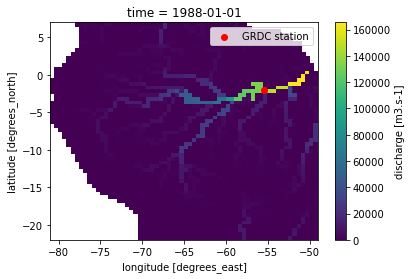

In [11]:
# for visualization purposed, it is also possible to plot variable from nc-file for given data
# and also location of GRDC station on the map
plt.figure()
pcrglobwb_utils.plotting.plot_var_at_timestep(ncf, var_name='discharge', time='1988-01-01')
plt.scatter(props['longitude'], props['latitude'], c='r', label='GRDC station')
plt.legend()

## Reading values files and visualzing them

### From GRDC file

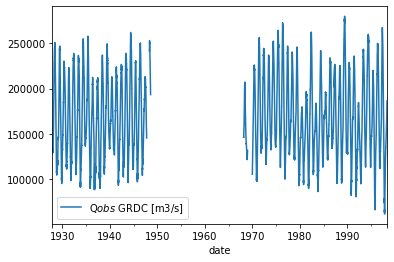

In [12]:
# reading values from GRDC station text file and providing a variable name
df_GRDC = grdc_obj.get_grdc_station_values(var_name=new_var_name_obs, plot=True)

In [25]:
GRDC_monthly = pcrglobwb_utils.time_funcs.calc_montly_avg(df_GRDC)

### From CSV file

If the file is not structured like GRDC files but a simple csv-file, we could do the same by reading from a non-GRDC formatted csv-file.

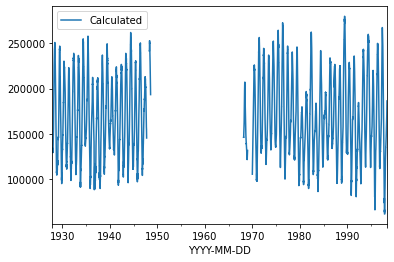

In [14]:
# first, create object 
csv_obj = pcrglobwb_utils.obs_data.other_data(csv_fo)
# second, apply method
df_CSV = csv_obj.get_values_from_csv(t_col='YYYY-MM-DD', v_col='Calculated', plot=True,
                                                          datetime_format='%d-%m-%Y')

In [26]:
csv_monthly = pcrglobwb_utils.time_funcs.calc_montly_avg(df_CSV)

### From nc-file

In [16]:
# create object first
nc_object = pcrglobwb_utils.nc_data.nc_data(ncf)

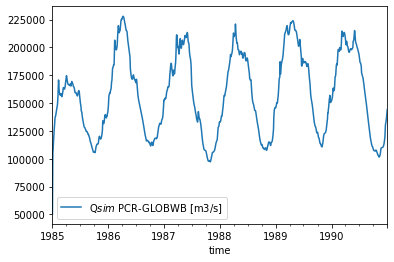

In [17]:
# apply method to read values at specific row and col
q_sim_obidos = nc_object.read_values_at_indices(row, col, plot_var_name=new_var_name_sim, plot=True)

In [27]:
q_sim_obidos_montly = pcrglobwb_utils.time_funcs.calc_montly_avg(q_sim_obidos, var_name=new_var_name_sim)

Text(0.5, 1.0, 'daily values')

<Figure size 432x288 with 0 Axes>

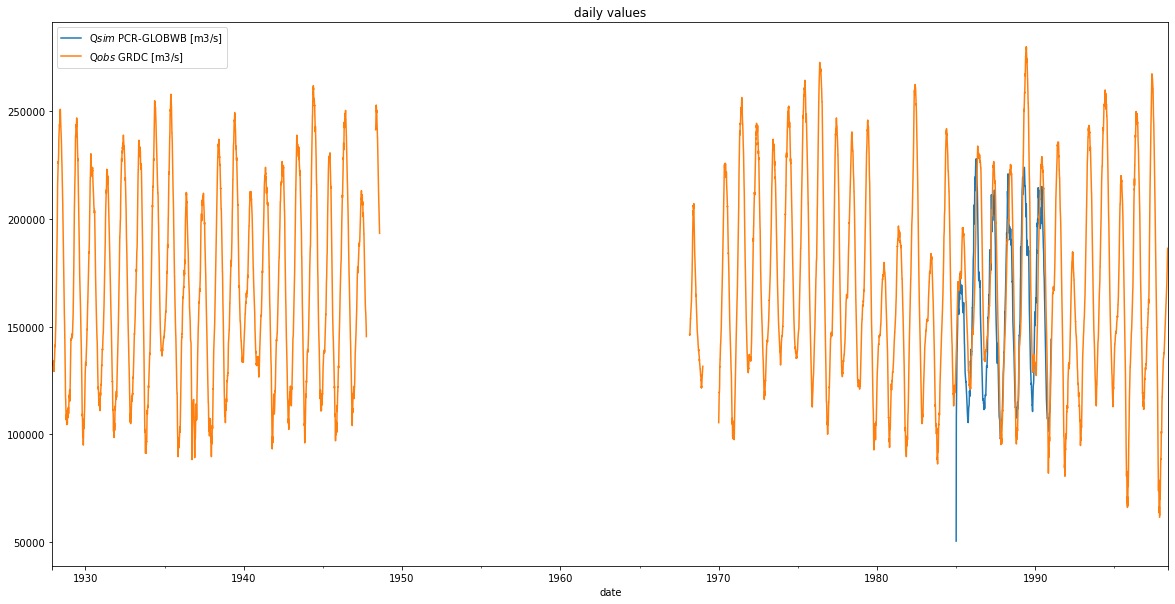

In [19]:
plt.figure()
q_sim_obidos.plot()
df_GRDC[new_var_name_obs].plot(figsize=(20,10))
plt.legend()
plt.title('daily values')

Text(0.5, 0, 'month')

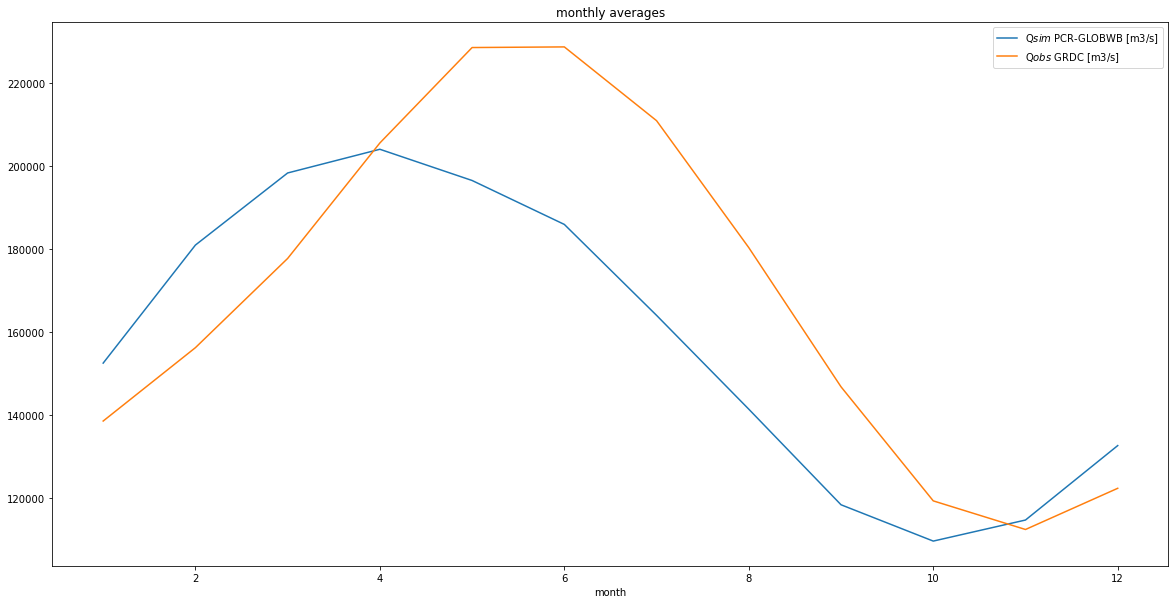

In [28]:
plt.figure()
ax = q_sim_obidos_montly.plot()
GRDC_monthly.plot(ax=ax, figsize=(20,10))
plt.legend()
plt.title('monthly averages')
plt.xlabel('month')

### Validation of daily values

{'KGE': 0.7121953016339049,
 'NSE': 0.49627672211755103,
 'RMSE': 30911.840814351533,
 'R2': 0.5995766148762273}

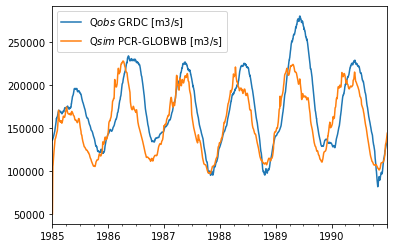

In [21]:
# validating simulations with observations for common time period
df_eval, eval_dic = nc_object.validate_results(df_GRDC, out_dir='./_OUT')
eval_dic

{'mean': 157987,
 'median': 157203,
 'max': 228026,
 'min': 50378,
 'q10': 110827,
 'q50': 157203,
 'q90': 209597}

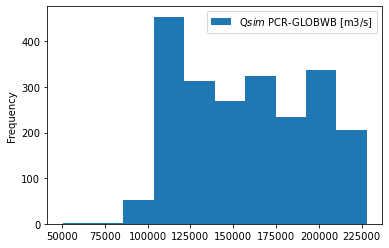

In [22]:
stats = nc_object.calc_stats(plot=True)
stats

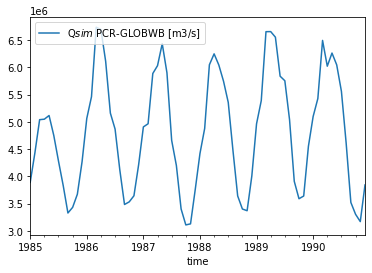

In [29]:
monthlyData = pcrglobwb_utils.time_funcs.daily2monthly(q_sim_obidos, plot=True)

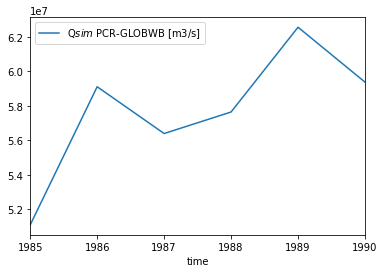

In [30]:
annualData = pcrglobwb_utils.time_funcs.daily2yearly(q_sim_obidos, plot=True)

In [31]:
annualData.head()

,Q$sim$ PCR-GLOBWB [m3/s]
time,
1985-12-31,51099408.0
1986-12-31,59101576.0
1987-12-31,56391880.0
1988-12-31,57639480.0
1989-12-31,62547704.0
